<a href="https://colab.research.google.com/github/ashkwart/Ashley-Website/blob/main/Week14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%config InlineBackend.figure_formats = ["retina"]

In [2]:
!pip install -q folium census seaborn geopandas

# Communities of Interest and Participatory Mapping

In this notebook, we're going to take a look at some crowdsourced data on **communities of interest**, gathered for redistricting purposes.  This data was collected by the Data and Democracy Lab in multiple states.  You can read a blog-style post about the project [here](https://mggg.org/cois).

Below, we'll explore the data collected in two states:  Michigan and Wisconsin.

In [3]:
import json

import census
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from census import Census
from functools import partial

In [4]:
!curl -O https://raw.githubusercontent.com/PUBPOL-2130/notebooks/refs/heads/main/data/mi_cois.json.zip
!curl -O https://raw.githubusercontent.com/PUBPOL-2130/notebooks/refs/heads/main/data/wi_cois.json.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26.0M  100 26.0M    0     0  26.5M      0 --:--:-- --:--:-- --:--:-- 26.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7176k  100 7176k    0     0  18.9M      0 --:--:-- --:--:-- --:--:-- 18.9M


In [5]:
!unzip mi_cois.json.zip
!unzip wi_cois.json.zip

Archive:  mi_cois.json.zip
  inflating: mi_cois.json            
Archive:  wi_cois.json.zip
  inflating: wi_cois.json            


In [6]:
mi_df = pd.read_json(open("mi_cois.json"), orient="records")

In [7]:
wi_df = pd.read_json(open("wi_cois.json"), orient="records")

Let's take a look at the Michigan dataframe.  Each community map has an ID, a title, and some narrative text.  If the community contains several areas, then each area is listed -- for instance, 17892-1 and 17892-2 are two parts of the same submission that is coded 17892.  There's also a list of which census blocks make up the area.

Finally, we had a team of humans (mainly me and a bunch of students!) apply labels by hand to each submission -- that's what's in the last column.  



In [8]:
mi_df

,districtr_id,submission_title,submission_text,area_name,area_text,blocks_2020,labels
0,17124-1,Dearborn Cultural District,Cultural venues in Dearborn. Important that th...,Community 1,None,"[261635799004005, 261639838003006, 26163983800...",[]
1,17128-1,Dearborn neighborhoods near Ford Field,"Area includes residents west of Brady, north o...",Dearborn Ford Field Neighbors,"Neighborhoods using Ford Field, north of Michi...","[261635749001029, 261635749001005, 26163579900...",[]
2,17892-1,Example: Grand Rapids center and exurbs,This map shows the Grand Rapids urban center a...,urban center,The denser and more urbanized part of Grand Ra...,"[260810016002007, 260810009002022, 26081013300...",[cities]
3,17892-2,Example: Grand Rapids center and exurbs,This map shows the Grand Rapids urban center a...,exurbs,"Extending past Hudsonville to the West, these ...","[260810133002001, 260810112003002, 26081011200...",[cities]
4,17892-1,ADA reviews,0,urban center,The denser and more urbanized part of Grand Ra...,"[260810016002007, 260810009002022, 26081013300...",[cities]
...,...,...,...,...,...,...,...
1032,41407-1,"Calhoun, Branch, Hillsdale map",Grouping of like community interests,District 1,None,"[260250015003035, 260239511003057, 26025002900...",[]
1033,41415-1,Congressional district map,Groups counties with like opinions and geograp...,District 1,None,"[260910606001000, 260250031002016, 26027001000...",[]
1034,41504-1,Lakeshore District - 79th,We need to ensure lakeshore communities are re...,District 1,None,"[261590114004032, 260210102011015, 26021000900...",[]
1035,41636-1,Keith B's Congressional Plan,These counties are more rural and agricultural...,District 1,None,"[260910606001000, 260250031002016, 26059051000...","[agriculture, nimby, suburbs]"


In [9]:
wi_df

,districtr_id,submission_title,submission_text,area_name,area_text,blocks_2020,labels
0,11542-1,Community of Interest (imported),How do the political lines in Wisconsin impact...,Lake Country,None,"[551332041003050, 551332042013001, 55133204400...",[named neighborhood]
1,11542-2,Community of Interest (imported),How do the political lines in Wisconsin impact...,Dousman/Summit,Rock River watershed,"[550551016001009, 551332041001033, 55133204004...","[environment, theory]"
2,11542-4,Community of Interest (imported),How do the political lines in Wisconsin impact...,Watertown south,None,"[550551011002026, 550551003012021, 55055101100...",[environment]
3,11623-1,Community of Interest (imported),Submitting on behalf of someone else?\nNo Rece...,Community 1,North Shore - my community of interest\nShorew...,"[550790703003009, 550790602004016, 55079080100...",[community engagement]
4,11623-2,Community of Interest (imported),Submitting on behalf of someone else?\nNo Rece...,Community 2,Brown Deer - sometimes included in the North S...,"[550790501031004, 550790501013027, 55079050104...",[personal-unusable-incoherent]
...,...,...,...,...,...,...,...
1145,33670-1,University of Wisconsin- Waukesha,This community of interest was drawn to ensur...,University of Wisconsin- Waukesha,The University of Wisconsin- Waukesha is the l...,"[551332031071001, 551332031072011, 55133203107...",[]
1146,34126-1,"Alexis' Map of Bay View, Milwaukee WI",This is my definition on the boundaries for Ba...,"Bay View, WI",Here's my take on the boundaries for the neigh...,"[550790180002041, 550790208003003, 55079020600...",[]
1147,34717-1,Iowa County functions as One Community,My community of interest is the entirety of Io...,Community of Iowa County,My community of interest is the entirety of Io...,"[550499504004045, 550499502001041, 55049950100...",[]
1148,34994-1,Unique Ecology Unites Unique Community,My community of interest is the entirety of Io...,Community of Iowa County,My community of interest is the entirety of Io...,"[550499504004045, 550499502001041, 55049950100...",[]


In [10]:
state_cois = {"Michigan": mi_df, "Wisconsin": wi_df}

In [11]:
for df in state_cois.values():
    df["coi_id"] = df["districtr_id"].str.split("-").str[0]

It's hard to look at all of these -- there are over a thousand in each state!  So let's take a random sample of a few of them to get a feeling for what they look like.   You can re-run the cell that prints out `sample_coi_text` several times and you'll get fresh random samples each time.

In [12]:
def sample_coi_text(df, n=10):
    sampled_cois = df["coi_id"].sample(n)
    for coi_id in sampled_cois:
        areas_df = df[df["coi_id"] == coi_id]
        labels = f"(labels: {', '.join(areas_df.iloc[0].labels)})" if areas_df.iloc[0].labels else ""
        print(f"-- COI: {areas_df.iloc[0].submission_title} {labels} (https://districtr.org/coi/{coi_id})")
        print(areas_df.iloc[0].submission_text, "\n")
        for _, area in areas_df.iterrows():
            if area.area_name:
                print(f"\t-- Area: {area.area_name}")
            if area.area_text:
                print(f"\t{area.area_text}")
        print()

In [13]:
sample_coi_text(state_cois["Michigan"])

-- COI: Dave's Greater Fenton Area Community.  (https://districtr.org/coi/31531)
Fenton and the greater area are a great place to live, raise a family and share the amenities of with one another. Please keep it whole in every way possible! 

	-- Area: Fenton City and Fenton Township Area
	Centered along US23, this area tends to be the center of the overall area representing my Community of Interest. 
All other areas denoted in my COI tend to run together, centered from Fenton.
The development in these areas run fairly contiguous throughout. With the overall COI area described then being bordered by countryside and farm land at roughly 90%. 
	-- Area: Linden-Argentine Area.
	-- Area: City of Holly and Holly Township.
	-- Area: Grand Blanc
	-- Area: Heartland Area

-- COI: Lansing Community of Interest (labels: k12) (https://districtr.org/coi/19892)
0 

	-- Area: West Lansing
	All Lansing addresses and most of Waverly school district and half of Lansing school (Sexton)
	-- Area: Lansing/

## What do people talk about?

In [14]:
for state, df in state_cois.items():
    label_counts = Counter()
    for labels in df["labels"]:
        label_counts.update(labels)

    print(f"-- {state}")
    print(pd.Series(label_counts).sort_values(ascending=False))
    print()

-- Michigan
agriculture                           156
economy-commerce-industry              95
suburbs                                78
k12                                    59
recreation-tourism                     58
nimby                                  50
cost-of-living-services-healthcare     45
diversity                              45
environment                            43
infrastructure                         36
university                             30
cities                                 27
family-children                        20
vulnerable populations                 16
religion                               15
technology                             14
community engagement                    9
elderly                                 9
poverty                                 8
culture                                 3
policing                                3
dtype: int64

-- Wisconsin
personal-unusable-incoherent          156
economy-commerce-industry            

Let's narrow it down to see what kinds of things people are saying.  For Michigan submissions that we labeled "agriculture," let's see the name, the full set of labels, a live link to the map, and the narrative text that accompanied the submission.  We'll look at a random sample of 5 of these.

In [15]:
mi_ag_df = state_cois["Michigan"][state_cois["Michigan"]["labels"].apply(lambda labels: len(labels) <= 3 and "agriculture" in labels)]

In [16]:
sample_coi_text(mi_ag_df, n=5)

-- COI: Calhoun County and Adjacent Farmland (labels: agriculture, nimby, suburbs) (https://districtr.org/coi/39319)
Calhoun County with Adjacent Farming Area and including Adjacent Military Establishments. Small City and College Area As Opposed to Large City and University. 

	-- Area: Calhoun and adjacent farmland
	Calhoun County with Adjacent Farming Area and including Adjacent Military Establishments. Small City and College Area As Opposed to Large City and University.

-- COI: US Congress - MI South Central (labels: agriculture, nimby) (https://districtr.org/coi/41383)
We need a US representative that is well versed in small farming communities, as our needs are different than those of bigger metropolitan cities. 

	-- Area: District 1

-- COI: Gail Ross: Shiawassee Senate District  (labels: agriculture) (https://districtr.org/coi/26629)
Please keep our current Senate District together. We share a very interconnected Community of Interest. Our counties are mostly made up of small 

Now what's going on with all those Wisconsin submissions labeled personal/unusable/incoherent?  When we investigate, we'll see that many times, the submission just doesn't say anything substantive.  This strongly suggests that the labeling team used labels a bit differently in the two states of Michigan vs Wisconsin.  (The reason is that the two groups that commissioned this work had different rules about what kinds of things can count!  The Michigan case had more specific rules, so that caused many things to be labeled unusable.)

In [17]:
wi_incoherent_df = state_cois["Wisconsin"][
    state_cois["Wisconsin"]["labels"].apply(lambda labels: len(labels) <= 3 and "personal-unusable-incoherent" in labels)
]

In [18]:
sample_coi_text(wi_incoherent_df)

-- COI: Community of Interest (imported) (labels: personal-unusable-incoherent) (https://districtr.org/coi/23184)
Submitting on behalf of someone else?
Yes Hudson couple from a mapping event 

	-- Area: Hudson Older Residential Community
	Established residential area of Hudson, with mixed generations, built in 50's and 60's, centered on EP Rock Elementary School

-- COI: https://districtr.org/COI/32741 (labels: diversity, cost of living-services-heatthcare, personal-unusable-incoherent) (https://districtr.org/coi/32741)
This community is mostly black people. Some important places are east capital Walmart, parks, east capital pick n save. Some important issues local official need to pay more attention to is Parks, buses, messmer high school, affordable housing.  The second community is majority White folks.  

	-- Area: Mia Map 07/22/2021
	This community is majority White folks. 

-- COI: Community of Interest (imported) (labels: cost of living-services-heatthcare, personal-unusable-inc

## Scale effects: what is a community, anyway?

Now let's do some data analysis on the submitted geographical areas.  We'll start by asking how many census blocks are in each one -- are the submitted "communities" more like neighborhoods or more like regions?

In [19]:
for df in state_cois.values():
    df["block_count"] = df["blocks_2020"].apply(len)

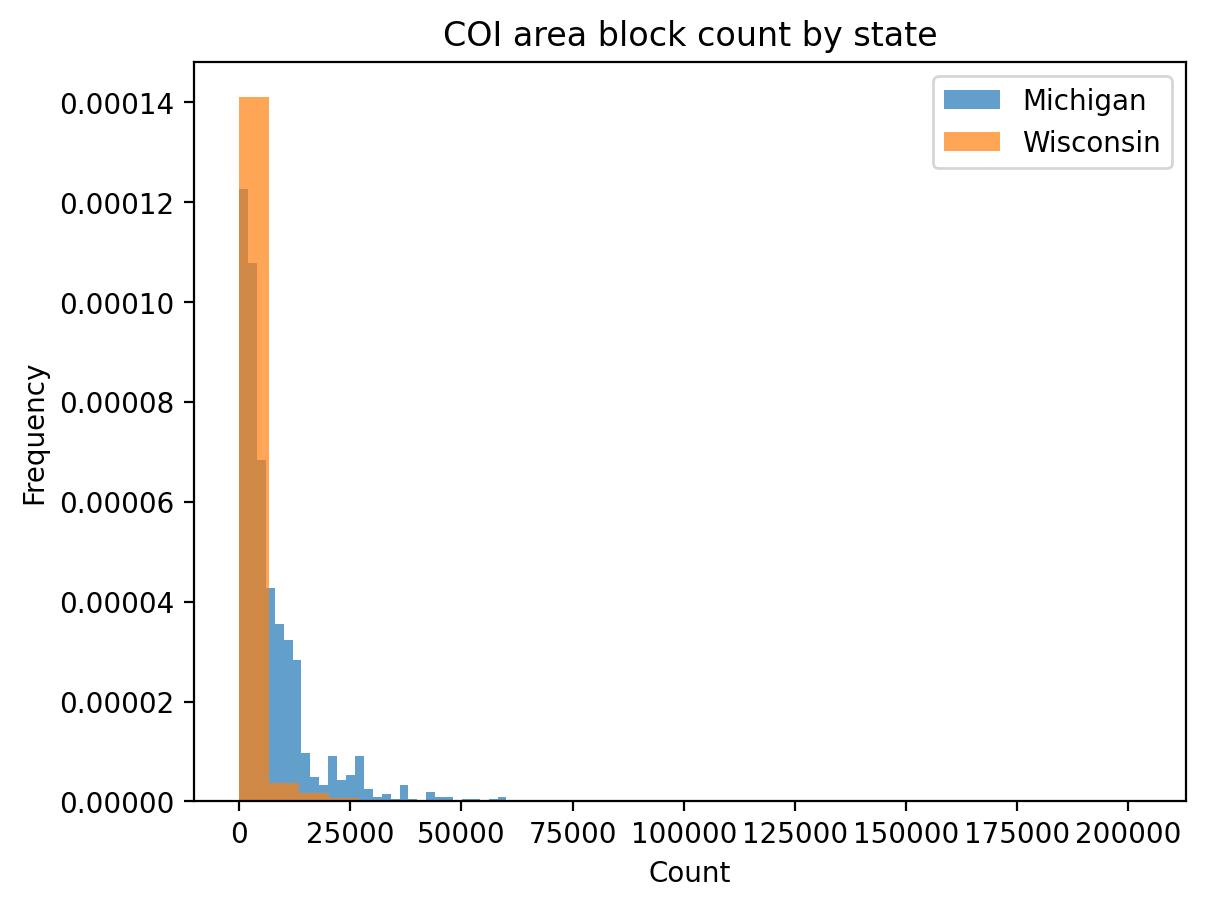

In [30]:
fig, ax = plt.subplots()
for state, df in state_cois.items():
    df["block_count"].plot.hist(label=state, alpha=0.7, bins=30, ax=ax, density=True)
plt.title("COI area block count by state")
plt.xlabel("Count")
plt.legend()
plt.show()

User-generated data is susceptible to extreme outliers. Let's remove the extreme tails and zoom in a bit...

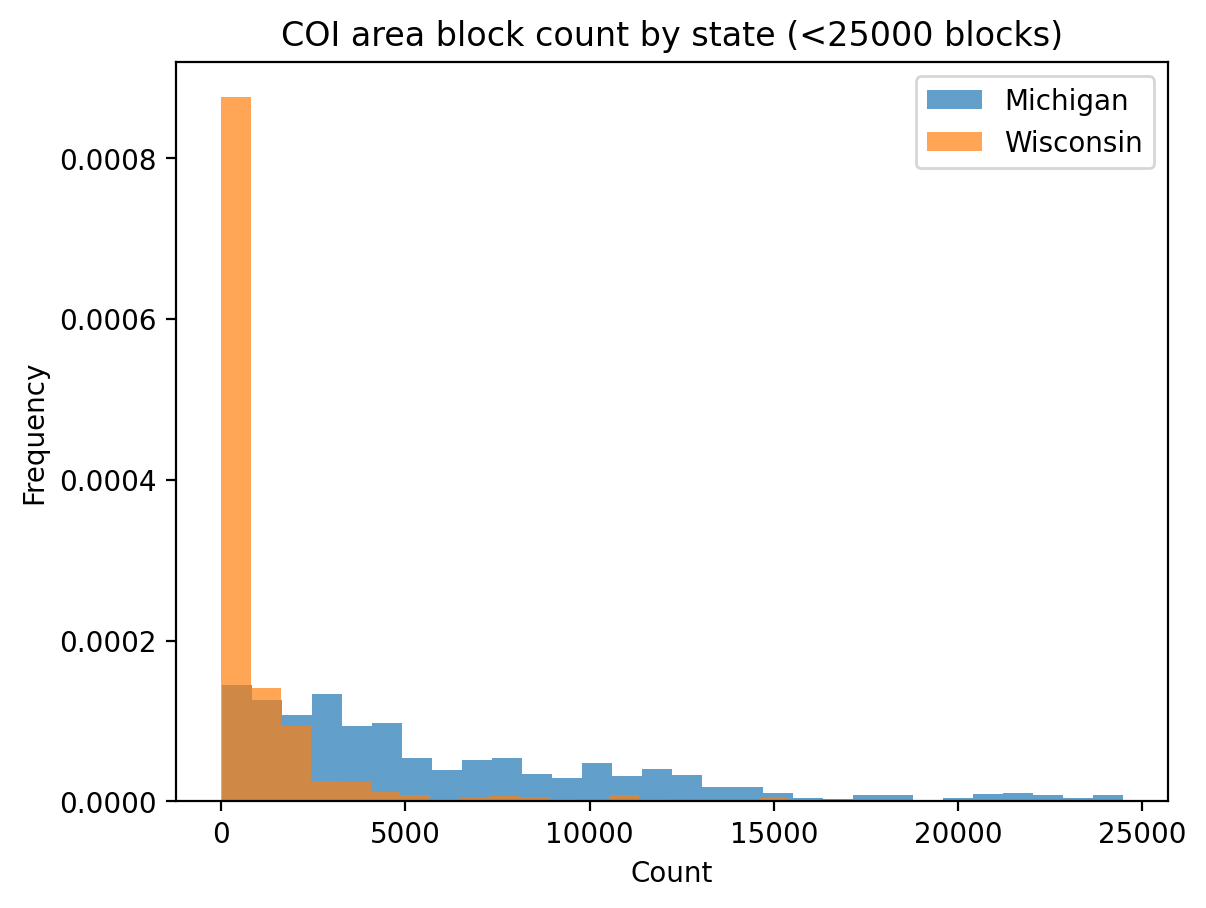

In [21]:
fig, ax = plt.subplots()
hist_params = dict(alpha=0.7, bins=30, ax=ax, density=True)
max_blocks = 25000
for state, df in state_cois.items():
    df["block_count"][df["block_count"] < max_blocks].plot.hist(label=state, alpha=0.7, bins=30, ax=ax, density=True)
plt.title(f"COI area block count by state (<{max_blocks} blocks)")
plt.xlabel("Count")
plt.legend()
plt.show()

OK that was a count of blocks in the COIs -- let's switch it up and do a comparison of land area.  

In [22]:
block_gdfs = {
    state: gpd.read_file(f"https://www2.census.gov/geo/tiger/TIGER2024/TABBLOCK20/tl_2024_{fips}_tabblock20.zip").set_index("GEOID20")
    for state, fips in zip(("Michigan", "Wisconsin"), ("26", "55"))
}

In [23]:
land_areas = {
    state: dict(gdf["ALAND20"])
    for state, gdf in block_gdfs.items()
}

In [24]:
for state, df in state_cois.items():
    df["land_area"] = df["blocks_2020"].apply(lambda blocks: sum(land_areas[state][geoid] for geoid in blocks))

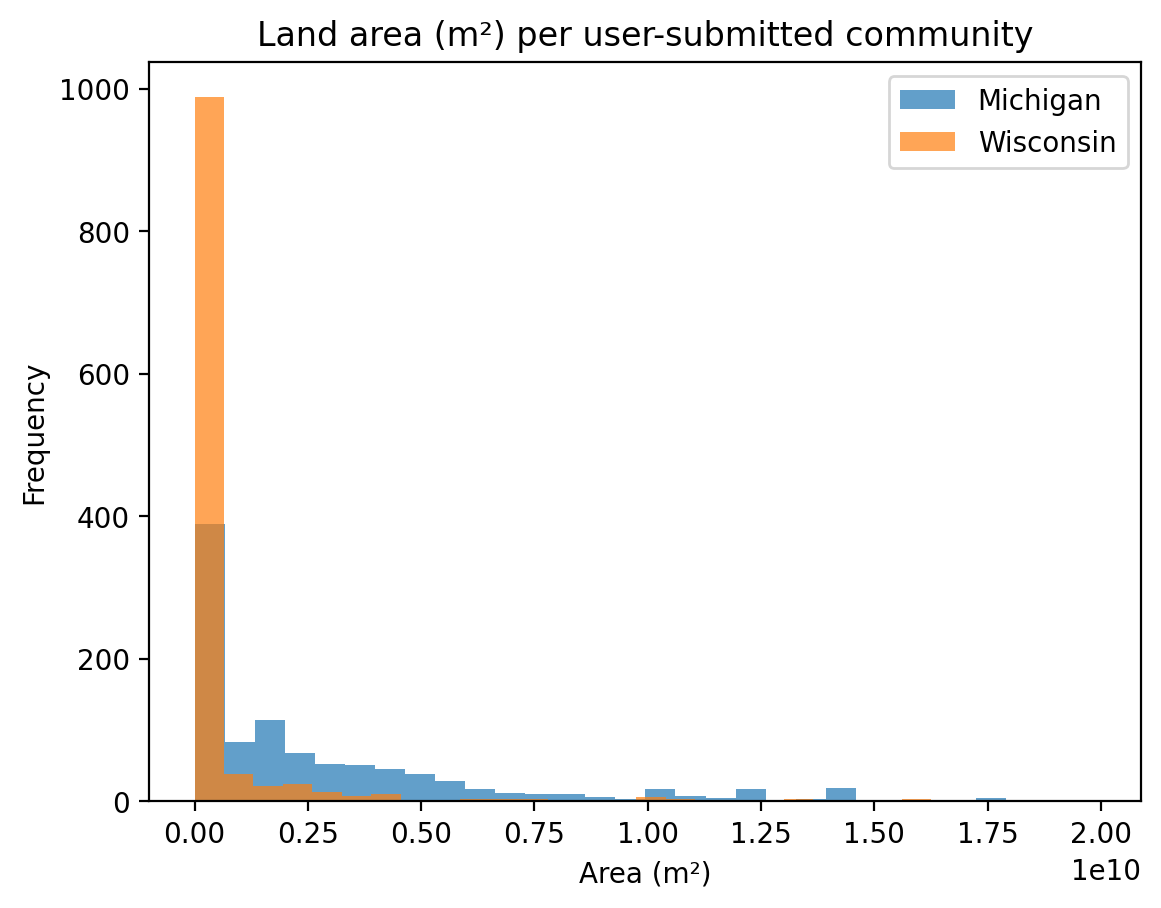

In [35]:
fig, ax = plt.subplots()
max_land_area = 2 * 10**10
for state, df in state_cois.items():
    df["land_area"][df["land_area"] < max_land_area].plot.hist(label=state, alpha=0.7, bins=30, ax=ax, density=False)
plt.title("Land area (m²) per user-submitted community")
plt.xlabel("Area (m²)")
plt.legend()

plt.savefig("land_area_pop.png")
plt.show()

One last little thing to try -- let's try to figure out if the small communities in Michigan are in fact *urban* neighborhoods.  One way to get that question is to single out Detroit, which makes up about 20% of the land area in Wayne County, but 80% of the population.

We'll filter down to user-submitted communities that are in Wayne (applying a threshold such as 80%) and see what share of the full dataset that captures.  Then, we'll plot the sizes of the communities in Wayne and out of Wayne to see if the big spike in very small communities happens in Detroit.

In [26]:
def mostly_in_county(geoids, fips, threshold=0.8):
  prefix_counts = Counter(geoid[:len(fips)] for geoid in geoids)
  return (prefix_counts[fips] / sum(prefix_counts.values())) >= threshold

state_cois["Michigan"]["mostly_in_wayne"] = state_cois["Michigan"]["blocks_2020"].apply(partial(mostly_in_county, fips="26163"))
state_cois["Wisconsin"]["mostly_in_milwaukee"] = state_cois["Wisconsin"]["blocks_2020"].apply(partial(mostly_in_county, fips="55079"))

In [27]:
print("there are",len(state_cois["Michigan"]),"COIs in the whole state")
print("and",state_cois["Michigan"]["mostly_in_wayne"].sum(),"COIs mostly in Wayne")

there are 1037 COIs in the whole state
and 101 COIs mostly in Wayne


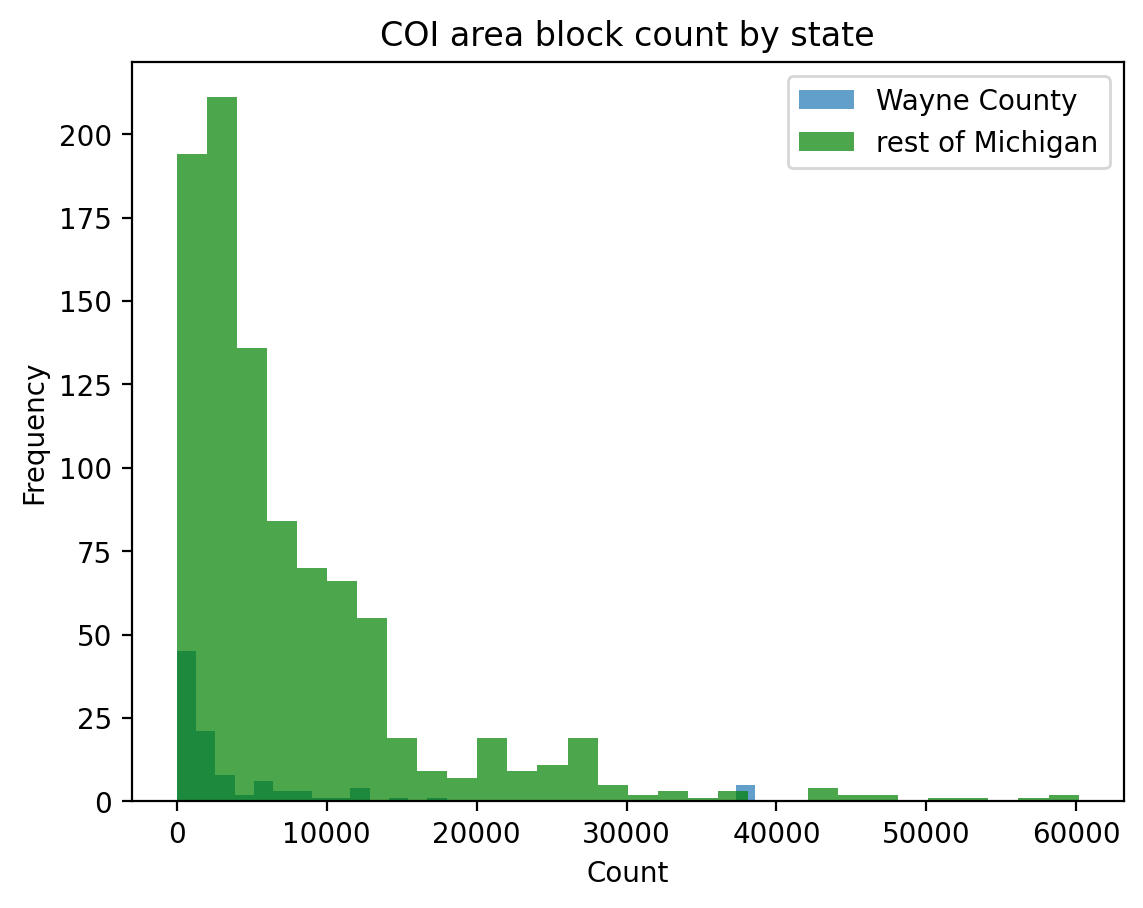

In [32]:
fig, ax = plt.subplots()
state_cois["Michigan"][state_cois["Michigan"]["mostly_in_wayne"]]["block_count"].plot.hist(label="Wayne County", alpha=0.7, bins=30, ax=ax, density=False)
state_cois["Michigan"][~state_cois["Michigan"]["mostly_in_wayne"]]["block_count"].plot.hist(label="rest of Michigan", alpha=0.7, bins=30, ax=ax, color="green", density=False)
plt.title("COI area block count by state")
plt.xlabel("Count")
plt.legend()
plt.show()

What do you think?  

#No more HW.  Enjoy the end of the semester!